# Análisis de Hiperparámetros para Ajedrez Vikingo

En este notebook, analizaremos los datos proporcionados para determinar la mejor configuración de hiperparámetros para los jugadores de ajedrez, diferenciando entre las blancas y las negras.

## MCTS 

### Lectura de datos

Vamos a leer los datos de los resultados de los experimentos realizados con MCTS.

In [92]:
import pandas as pd

df = pd.read_csv('./results/result_mcts.csv')
df.head()

,simulations_number_whites,exploration_factor_whites,simulations_number_blacks,exploration_factor_blacks,average_time_whites,chess_pieces_whites,average_time_blacks,chess_pieces_blacks,result
0,100,1.0,100,0.0,0.950926,8.0,0.950926,3,Ganan blancas
1,100,1.0,100,0.0,1.017034,3.0,1.017034,6,Ganan blancas
2,100,1.0,100,0.0,1.089101,1.0,1.089101,6,Ganan negras
3,100,1.0,100,0.0,1.042461,3.0,1.042461,0,Ganan negras
4,100,1.0,100,0.0,1.067558,7.0,1.067558,3,Ganan blancas


El dataset contiene los siguientes campos por cada partida

* **simulations_number_whites:** Número de simulaciones para las fichas blancas.
* **exploration_factor_whites:** Factor de exploración para las fichas blancas.
* **simulations_number_blacks:** Número de simulaciones para las fichas negras.
* **exploration_factor_blacks:** Factor de exploración para las fichas negras.
* **average_time_whites:** Media de tiempo en realizar un movimiento para las fichas blancas.
* **chess_pieces_whites:** Fichas capturadas por las fichas blancas.
* **average_time_blacks:** Media de tiempo en realizar un movimiento para las fichas negras.
* **chess_pieces_blacks** Fichas capturadas por las fichas negras.
* **result:** Resultado de la partida.

Durante el experimento se ha enfrentado cada agente con el resto.

## Preprocesado

En esta sección preprocesaremos el dataset para asignar el nombre de los agentes implicados en una partida al dataset a través de sus hiperparámetros. Durante el experimento, los 4 agentes que se han probado contaban con las siguientes características:

In [93]:
from math import sqrt

agentes = {
    "Agente MCTS 1": {
        "simulations_number": 100,
        "exploration_factor": 1,
    },
    "Agente MCTS 2": {
        "simulations_number": 100,
        "exploration_factor": 0,
    },
    "Agente MCTS 3": {
        "simulations_number": 100,
        "exploration_factor": 0.5,
    },
    "Agente MCTS 4": {
        "simulations_number": 200,
        "exploration_factor": 1 / sqrt(2),
        
    },
}

In [94]:
datos = df.copy()

# Creamos un mapeo inverso basado en simulations_number y exploration_factor para cada agente
agent_mapping = {
    (agent_info["simulations_number"], agent_info["exploration_factor"]): idx 
    for idx, agent_info in agentes.items()
}

# Función para obtener el nombre del agente basado en simulations_number y exploration_factor
def get_agent_name(simulations_number, exploration_factor):
    return agent_mapping.get((simulations_number, exploration_factor))

# Aplicamos la transformación para crear las nuevas columnas 'whites' y 'blacks'
datos['whites'] = datos.apply(lambda row: get_agent_name(row['simulations_number_whites'], row['exploration_factor_whites']), axis=1)
datos['blacks'] = datos.apply(lambda row: get_agent_name(row['simulations_number_blacks'], row['exploration_factor_blacks']), axis=1)

# Eliminamos las columnas originales
datos = datos.drop(columns=[
    'simulations_number_whites',
    'exploration_factor_whites',
    'simulations_number_blacks',
    'exploration_factor_blacks'
])

datos.head()


,average_time_whites,chess_pieces_whites,average_time_blacks,chess_pieces_blacks,result,whites,blacks
0,0.950926,8.0,0.950926,3,Ganan blancas,Agente MCTS 1,Agente MCTS 2
1,1.017034,3.0,1.017034,6,Ganan blancas,Agente MCTS 1,Agente MCTS 2
2,1.089101,1.0,1.089101,6,Ganan negras,Agente MCTS 1,Agente MCTS 2
3,1.042461,3.0,1.042461,0,Ganan negras,Agente MCTS 1,Agente MCTS 2
4,1.067558,7.0,1.067558,3,Ganan blancas,Agente MCTS 1,Agente MCTS 2


## Visualización

En esta sección realizaremos distintas visualizaciones de los resultados obtenidos para poder comprenderlos mejor. Comenzamos calculando el número de victorias por cada agente y color que ha jugado.

In [95]:
def calcula_numero_victorias(datos, agente, color="blancas"):
    
    if color == "blancas":
        return len(datos[(datos["result"]=="Ganan blancas") & (datos["whites"]==agente)]) 
    elif color == "negras":
        return len(datos[(datos["result"]=="Ganan negras") & (datos["blacks"]==agente)]) 
    else:
        raise AttributeError("El atributo 'color' deber tomar el valor 'blancas' o 'negras'")

victorias_con_blancas = {}
victorias_con_negras = {}

for agente in agentes:
    victorias_con_blancas[agente] = calcula_numero_victorias(datos, agente)
    victorias_con_negras[agente] = calcula_numero_victorias(datos, agente, color="negras")
    
print(f"Victorias con blancas:\n{victorias_con_blancas}")
print(f"Victorias con negras:\n{victorias_con_negras}")

Victorias con blancas:
{'Agente MCTS 1': 11, 'Agente MCTS 2': 13, 'Agente MCTS 3': 12, 'Agente MCTS 4': 12}
Victorias con negras:
{'Agente MCTS 1': 0, 'Agente MCTS 2': 5, 'Agente MCTS 3': 2, 'Agente MCTS 4': 5}


Visualizamos los resultados de las partidas ganadas haciendo uso de las librerías *matplotlib* y *seaborn* y utilizaremos gráficas circulares.

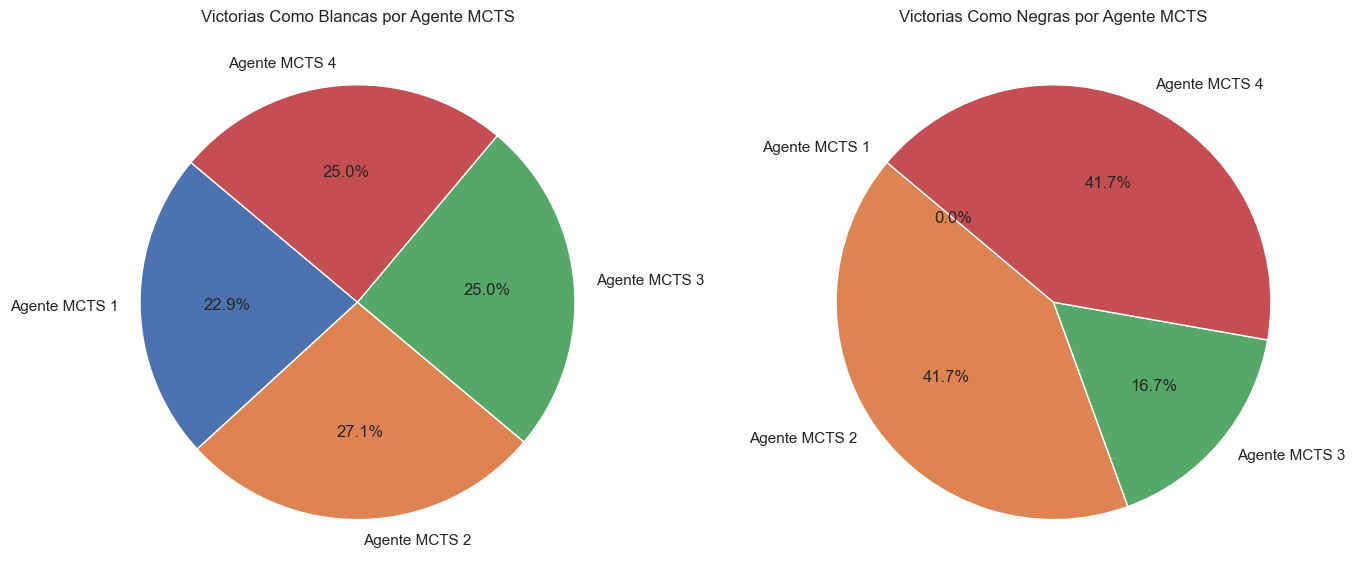

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].pie(victorias_con_blancas.values(), labels=victorias_con_blancas.keys(), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Victorias Como Blancas por Agente MCTS')

axs[1].pie(victorias_con_negras.values(), labels=victorias_con_negras.keys(), autopct='%1.1f%%', startangle=140)
axs[1].set_title('Victorias Como Negras por Agente MCTS')

plt.tight_layout()
plt.show()

Observamos que agente ha conseguido más victorias; para las blancas el agente 2 es el ganador, mientras que para las negras hay un empate entre el agente 4 y 2.

Definimos una función para crear gráficas *strip plot*. Estas gráficas muestran la distribución de los datos.

In [97]:
def create_strip_plot(data, y, title):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.stripplot(data=data, x="whites", y=f"{y}_whites", ax=axs[0])
    sns.stripplot(data=data, x="blacks", y=f"{y}_blacks", ax=axs[1])
    
    axs[0].set_title(title + " al jugar con blancas")
    axs[1].set_title(title + " al jugar con negras")
    
    plt.show()

También definiremos una función que calcula la media de una variable para un conjunto de datos.

In [98]:
def calcula_medias_variable(datos, variable):

    capturas_agentes_blancas = datos.groupby("whites")[f"{variable}_whites"].mean()
    capturas_agentes_negras = datos.groupby("blacks")[f"{variable}_blacks"].mean()

    capturas_agentes_blancas = capturas_agentes_blancas.reset_index().rename(columns={"whites": "Agente", f"{variable}_whites": "Blancas"})
    capturas_agentes_negras = capturas_agentes_negras.reset_index().rename(columns={"blacks": "Agente", f"{variable}_blacks": "Negras"})

    capturas_agentes = pd.merge(capturas_agentes_blancas, capturas_agentes_negras, on="Agente")

    return capturas_agentes

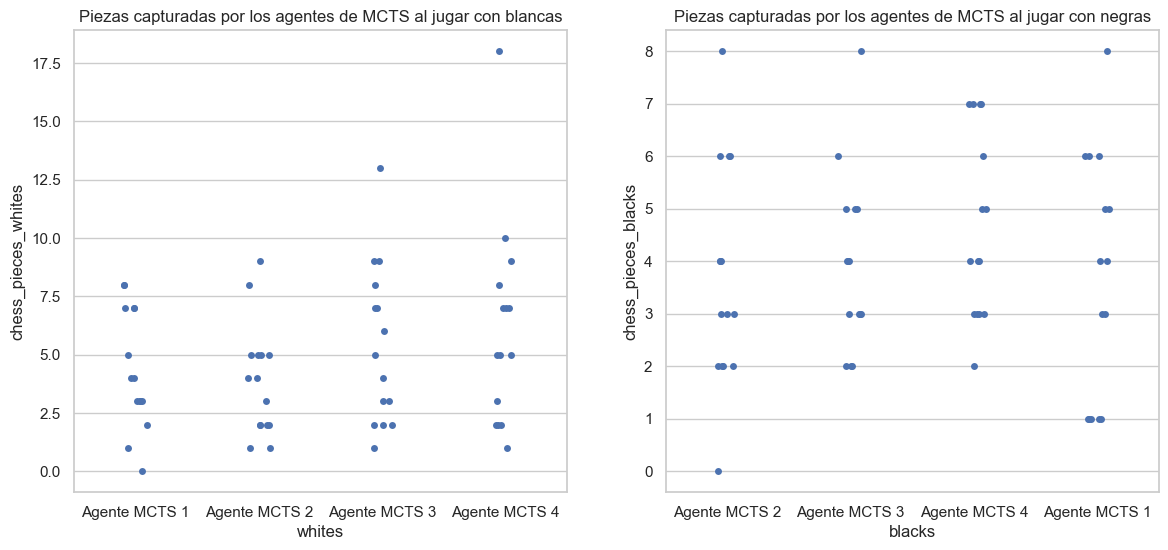

In [99]:
create_strip_plot(datos, "chess_pieces", "Piezas capturadas por los agentes de MCTS")

          Agente   Blancas    Negras
0  Agente MCTS 1  4.333333  3.666667
1  Agente MCTS 2  3.866667  3.666667
2  Agente MCTS 3  5.400000  3.933333
3  Agente MCTS 4  6.066667  4.666667


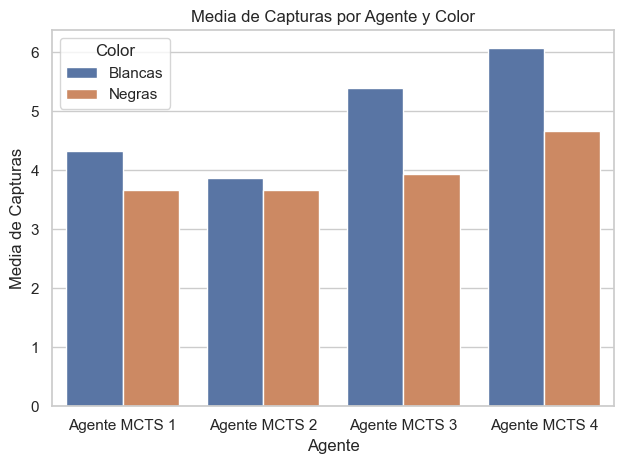

In [100]:
capturas_agentes = calcula_medias_variable(datos, "chess_pieces")

print(capturas_agentes)

# Extendemos el dataframe para que exista una columna 'Color' que indique si la ficha es blanca o negra
captura_agentes_extendido = pd.melt(capturas_agentes, id_vars=['Agente'], value_vars=['Blancas', 'Negras'],
                                var_name='Color', value_name='Media Capturas')

# Mostramos la gráfica
ax = sns.barplot(x='Agente', y='Media Capturas', hue='Color', data=captura_agentes_extendido)

plt.title('Media de Capturas por Agente y Color')
plt.xlabel('Agente')
plt.ylabel('Media de Capturas')
plt.legend(title='Color')

plt.tight_layout()
plt.show()

Hemos mostrado la media de fichas capturadas por cada agente jugando con colores distintos. Previamente, para las fichas blancas vimos que el agente 2 había conseguido, por muy poco, el agente con más victorias y comparandolos con esta gráfica podemos observar que es el que menos fichas ha capturado para el color blanco, siendo el agente 4 el que más fichas ha capturado. Viendo las fichas negras, el agente 4 es el que ha obtenido la mayor media de fichas capturadas.

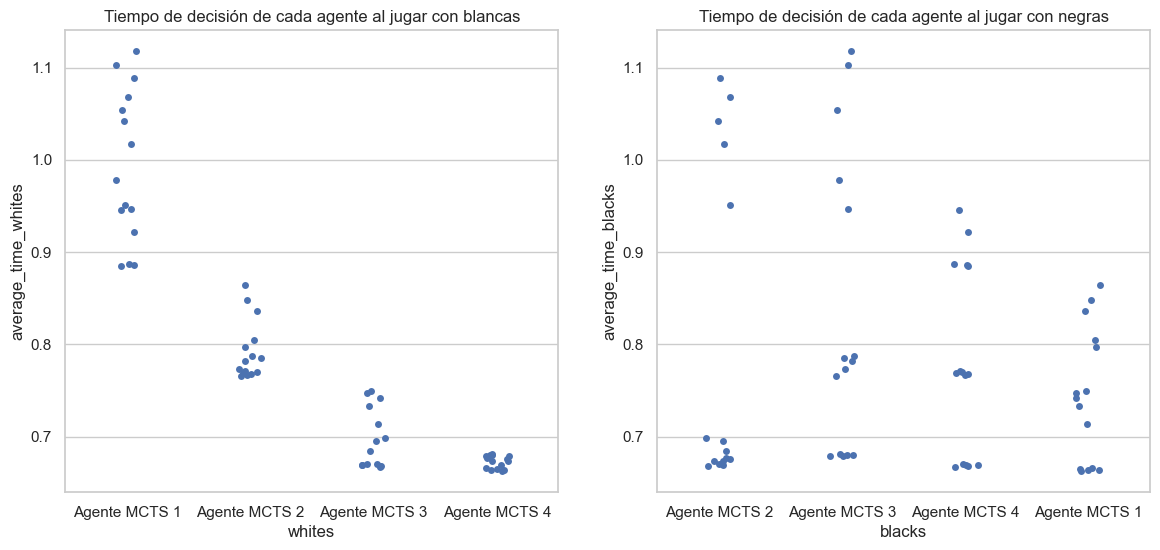

In [101]:
create_strip_plot(datos, 'average_time', 'Tiempo de decisión de cada agente')

Estas gráficas muestra la distribución del tiempo promedio de juego para las fichas blancas y negras, además de la cantidad de piezas de ajedrez capturadas al final de la partida. Los diferentes colores representan los distintos resultados de las partidas. Esta gráfica puede ayudar a entender si un juego más largo o más corto beneficia a las blancas en términos de cantidad de piezas restantes o en la probabilidad de ganar la partida.

Calcularemos la media de tiempos por cada agente y color.

          Agente   Blancas    Negras
0  Agente MCTS 1  0.992865  0.743806
1  Agente MCTS 2  0.792448  0.796804
2  Agente MCTS 3  0.696470  0.832708
3  Agente MCTS 4  0.672507  0.780972


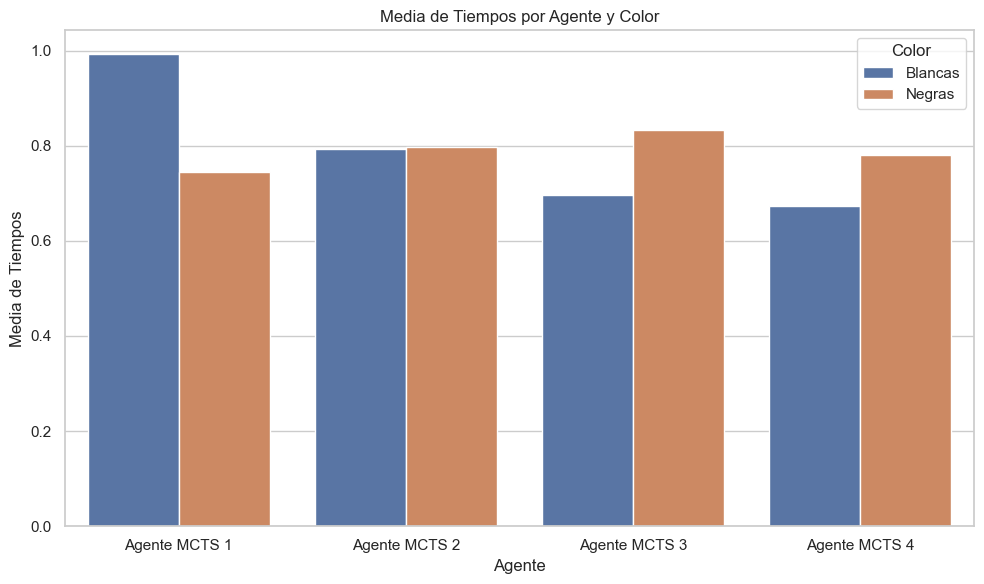

In [102]:
tiempo_agentes = calcula_medias_variable(datos, "average_time")

print(tiempo_agentes)

tiempo_agentes_extendido = pd.melt(tiempo_agentes, id_vars=['Agente'], value_vars=['Blancas', 'Negras'],
                                var_name='Color', value_name='Media_Tiempos')

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Agente', y='Media_Tiempos', hue='Color', data=tiempo_agentes_extendido)

plt.title('Media de Tiempos por Agente y Color')
plt.xlabel('Agente')
plt.ylabel('Media de Tiempos')
plt.legend(title='Color')

plt.tight_layout()
plt.show()

Ahora podemos observar que es el agente 1 el que ha conseguido una mejor media de tiempos para las blancas, y siendo el agente 3 para las negras.

Definimos una función para crear gráficas de barras. Estas gráficas muestran la relación entre dos variables.

In [103]:
sns.set(style="whitegrid")

def create_bar_plot(data, x_column, y_column, title):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.barplot(data=data, x=f"{x_column}_whites", y=f"{y_column}_whites", ax=axs[0], ci=None)
    sns.barplot(data=data, x=f"{x_column}_blacks", y=f"{y_column}_blacks", ax=axs[1], ci=None)
    
    axs[0].set_title(title + " al jugar con blancas")
    axs[1].set_title(title + " al jugar con negras")

    plt.show()

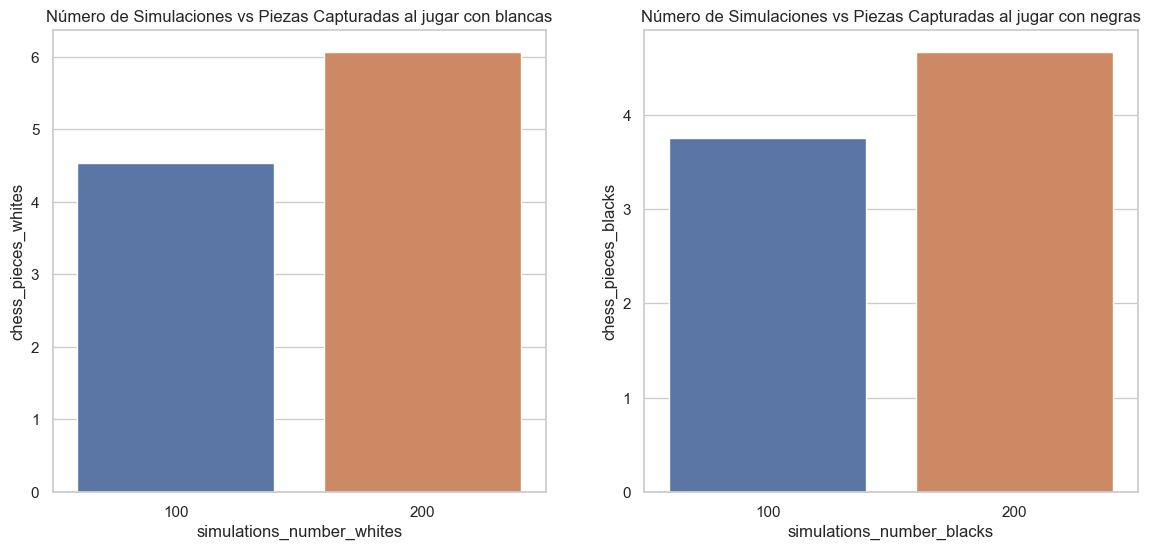

In [104]:
create_bar_plot(df, 'simulations_number', 'chess_pieces', 'Número de Simulaciones vs Piezas Capturadas')

Se observa que un número de simulaciones más alto hace que se capturen más fichas. 

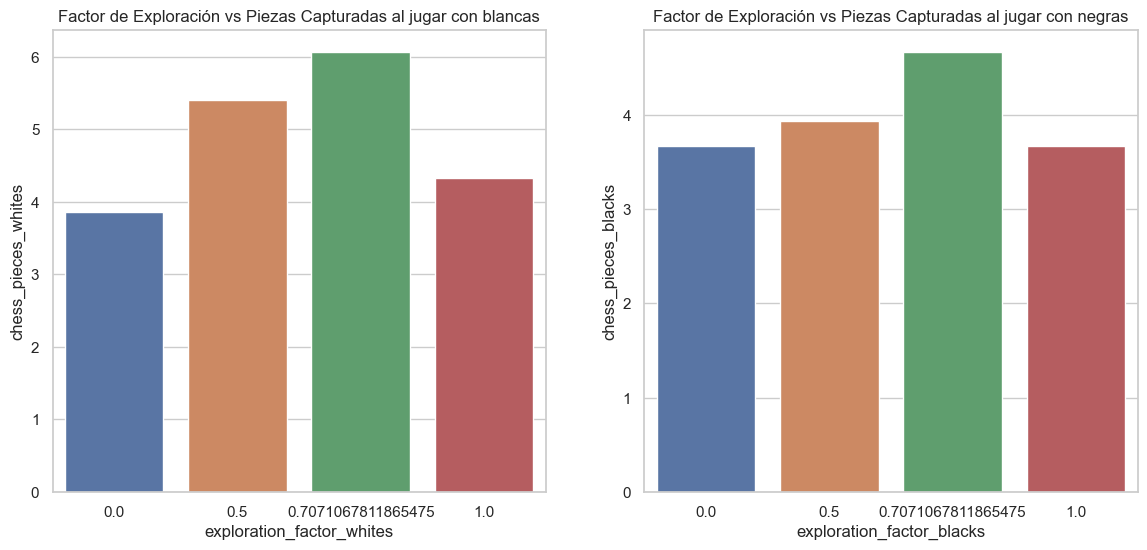

In [105]:
create_bar_plot(df, 'exploration_factor', 'chess_pieces', 'Factor de Exploración vs Piezas Capturadas')

Observamos que el valor que más fichas ha capturado es $ \frac{1}{\sqrt{2}} $

### Conclusiones

Para elaborar unas conclusiones sobre la elección de qué configuración de hiperparámetros es la mejor hemos definido una función que muestra de forma conjunta el número de victorias, las fichas capturas y el tiempo promedio para cada agente.

In [106]:
def evaluar_agentes(datos, color):
    
    if color == 'blancas':
        columna_agrupacion = "whites"
        columna_tiempo = 'average_time_whites'
        columna_fichas = 'chess_pieces_whites'
        condicion_victoria = datos['result'] == 'Ganan blancas'
    else:
        columna_agrupacion = "blacks"
        columna_tiempo = 'average_time_blacks'
        columna_fichas = 'chess_pieces_blacks'
        condicion_victoria = datos['result'] == 'Ganan negras'
    
    resultados = datos.groupby(columna_agrupacion).apply(
        lambda x: pd.Series({
            'Ratio_Victorias': x[condicion_victoria].shape[0] / x.shape[0],
            'Fichas_Promedio': x[columna_fichas].mean(),
            'Tiempo_Promedio': x[columna_tiempo].mean()
        })
    )
    
    resultados_ordenados = resultados.sort_values(by=['Ratio_Victorias', 'Fichas_Promedio', 'Tiempo_Promedio'], ascending=[False, False, True])
    
    return resultados_ordenados


In [107]:
import warnings
warnings.filterwarnings('ignore')

resultados_blancas = evaluar_agentes(datos, 'blancas')
resultados_blancas

,Ratio_Victorias,Fichas_Promedio,Tiempo_Promedio
whites,,,
Agente MCTS 2,0.866667,3.866667,0.792448
Agente MCTS 4,0.800000,6.066667,0.672507
Agente MCTS 3,0.800000,5.400000,0.696470
Agente MCTS 1,0.733333,4.333333,0.992865


In [108]:
resultados_negras = evaluar_agentes(datos, 'negras')
resultados_negras

,Ratio_Victorias,Fichas_Promedio,Tiempo_Promedio
blacks,,,
Agente MCTS 4,0.333333,4.666667,0.780972
Agente MCTS 2,0.333333,3.666667,0.796804
Agente MCTS 3,0.133333,3.933333,0.832708
Agente MCTS 1,0.000000,3.666667,0.743806


Estos valores representan las configuraciones más comunes entre los juegos ganados por las fichas blancas y negras, respectivamente. Para las blancas la mejor configuración sería la del Agente 2, mientras que para las negras habría que tener en cuenta las gráficas anteriores porque a pesar de que tanto el Agente 2 como el 4 habían ganado el mismo porcentaje de partidas, pero el Agente 4 había conseguido mejor rendimiento en captura de fichas y tiempo, por lo que para las negras la mejor configuración es el agente 4.

Por tanto, la configuración de blancas sería:
* **Número de simulaciones:** 100
* **Factor de exploración:** 0.0

Y para negras sería:
* **Número de simulaciones:** 100
* **Factor de exploración:** $ \frac{1}{\sqrt{2}} $



## Q-Learning

### Lectura de datos

Vamos a leer los datos de los resultados de los experimentos realizados con Q-Learning.

In [109]:
df = pd.read_csv('./results/result_qlearning.csv')
df.head()

,learning_rate_whites,initial_epsilon_whites,epsilon_decay_whites,final_epsilon_whites,learning_rate_blacks,initial_epsilon_blacks,epsilon_decay_blacks,final_epsilon_blacks,average_time_whites,chess_pieces_whites,average_time_blacks,chess_pieces_blacks,result
0,0.2,0.9,0.85,0.05,0.05,0.5,0.95,0.2,0.000138,1.0,0.000138,8.0,Ganan negras
1,0.2,0.9,0.85,0.05,0.05,0.5,0.95,0.2,0.000126,6.0,0.000126,4.0,Ganan negras
2,0.2,0.9,0.85,0.05,0.05,0.5,0.95,0.2,0.000123,7.0,0.000123,3.0,Ganan blancas
3,0.2,0.9,0.85,0.05,0.05,0.5,0.95,0.2,0.000125,11.0,0.000125,5.0,Ganan blancas
4,0.2,0.9,0.85,0.05,0.05,0.5,0.95,0.2,0.000123,4.0,0.000123,5.0,Ganan negras


El dataset contiene los siguientes campos por cada partida:
* **learning_rate_whites:** Tasa de aprendizaje para las fichas blancas.
* **initial_epsilon_whites:** Valor inicial de epsilon para las fichas blancas.
* **epsilon_decay_whites:** Factor de decaimiento de epsilon para las fichas blancas.
* **final_epsilon_whites:** Valor final de epsilon para las fichas blancas.
* **learning_rate_blacks:** Tasa de aprendizaje para las fichas negras.
* **initial_epsilon_blacks:** Valor inicial de epsilon para las fichas negras.
* **epsilon_decay_blacks:** Factor de decaimiento de epsilon para las fichas negras.
* **final_epsilon_blacks:** Valor final de epsilon para las fichas negras.
* **average_time_whites:** Media de tiempo en realizar un movimiento para las fichas blancas.
* **chess_pieces_whites:** Fichas capturadas por las fichas blancas.
* **average_time_blacks:** Media de tiempo en realizar un movimiento para las fichas negras.
* **chess_pieces_blacks** Fichas capturadas por las fichas negras.
* **result:** Resultado de la partida.

## Preprocesado

En esta sección preprocesaremos el dataset para asignar el nombre de los agentes implicados en una partida al dataset a través de sus hiperparámetros. Durante el experimento, los 4 agentes que se han probado contaban con las siguientes características:

In [110]:
agentes = {
    "Agente Q1": {
        "learning_rate": 0.2,
        "initial_epsilon": 0.9,
        "epsilon_decay": 0.85,
        "final_epsilon": 0.05
    },
    "Agente Q2": {
        "learning_rate": 0.05,
        "initial_epsilon": 0.5,
        "epsilon_decay": 0.95,
        "final_epsilon": 0.2
    },
    "Agente Q3": {
        "learning_rate": 0.15,
        "initial_epsilon": 0.8,
        "epsilon_decay": 0.92,
        "final_epsilon": 0.1
    },
    "Agente Q4": {
        "learning_rate": 0.07,
        "initial_epsilon": 0.7,
        "epsilon_decay": 0.97,
        "final_epsilon": 0.15
    }
}

In [111]:
datos = df.copy()

agent_mapping = {
    (agent_info["learning_rate"], 
     agent_info["initial_epsilon"], 
     agent_info["epsilon_decay"], 
     agent_info["final_epsilon"]): idx 
    
    for idx, agent_info in agentes.items()
}

def get_agent_name(learning_rate, initial_epsilon, epsilon_decay, final_epsilon):
    return agent_mapping.get((learning_rate, initial_epsilon, epsilon_decay, final_epsilon))

datos['whites'] = datos.apply(lambda row: get_agent_name(row["learning_rate_whites"], row["initial_epsilon_whites"], row["epsilon_decay_whites"], row["final_epsilon_whites"]), axis=1)
datos['blacks'] = datos.apply(lambda row: get_agent_name(row["learning_rate_blacks"], row["initial_epsilon_blacks"], row["epsilon_decay_blacks"], row["final_epsilon_blacks"]), axis=1)

datos = datos.drop(columns=[
    'learning_rate_whites',
    'initial_epsilon_whites',
    'epsilon_decay_whites',
    'final_epsilon_whites',
    'learning_rate_blacks',
    'initial_epsilon_blacks',
    'epsilon_decay_blacks',
    'final_epsilon_blacks'
])

datos.head()

,average_time_whites,chess_pieces_whites,average_time_blacks,chess_pieces_blacks,result,whites,blacks
0,0.000138,1.0,0.000138,8.0,Ganan negras,Agente Q1,Agente Q2
1,0.000126,6.0,0.000126,4.0,Ganan negras,Agente Q1,Agente Q2
2,0.000123,7.0,0.000123,3.0,Ganan blancas,Agente Q1,Agente Q2
3,0.000125,11.0,0.000125,5.0,Ganan blancas,Agente Q1,Agente Q2
4,0.000123,4.0,0.000123,5.0,Ganan negras,Agente Q1,Agente Q2


## Visualización 

Para cada agente se ha definido una tasa de aprendizaje, un valor inicial de epsilon, un factor de decaimiento de epsilon y un valor final de epsilon. La tasa de aprendizaje indica la importancia relativa de los nuevos conocimientos frente a los antiguos. El valor inicial de epsilon indica la importancia relativa de la exploración (movimientos aleatorios) frente a la explotación (movimientos basados en la experiencia) al comienzo del entrenamiento. El factor de decaimiento de epsilon indica la rapidez con la que se reduce la importancia de la exploración a lo largo del entrenamiento. El valor final de epsilon indica la importancia relativa de la exploración al final del entrenamiento. Se ha enfrentado entre sí a cada agente, alternando el color de las fichas en cada partida.

Calcularemos las victorias por agente y color, y la visualizaremos mediante una gráfica circular.

In [112]:
victorias_con_blancas = {}
victorias_con_negras = {}

for agente in agentes:
    victorias_con_blancas[agente] = calcula_numero_victorias(datos, agente)
    victorias_con_negras[agente] = calcula_numero_victorias(datos, agente, "negras")
    
print(f"Victorias con blancas:\n{victorias_con_blancas}")
print(f"Victorias con negras:\n{victorias_con_negras}")

Victorias con blancas:
{'Agente Q1': 8, 'Agente Q2': 6, 'Agente Q3': 7, 'Agente Q4': 8}
Victorias con negras:
{'Agente Q1': 8, 'Agente Q2': 6, 'Agente Q3': 7, 'Agente Q4': 9}


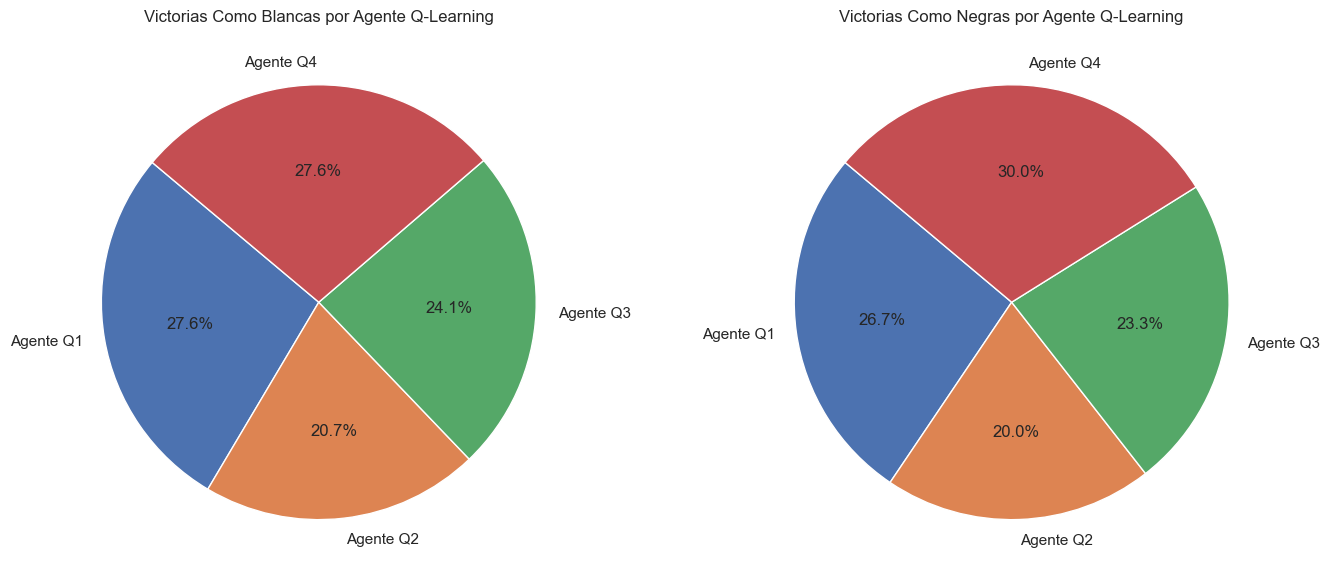

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].pie(victorias_con_blancas.values(), labels=victorias_con_blancas.keys(), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Victorias Como Blancas por Agente Q-Learning')

axs[1].pie(victorias_con_negras.values(), labels=victorias_con_negras.keys(), autopct='%1.1f%%', startangle=140)
axs[1].set_title('Victorias Como Negras por Agente Q-Learning')

plt.tight_layout()
plt.show()

Observamos que, de todos los agentes, el agente 1 y 4 son los que han conseguido un mayor porcentaje de partidas ganadas usando las fichas blancas. Mientras, para las negras el agente 4 es el que ha conseguido un mayor número de victorias.

Visualizaremos la distribución de los datos mediante gráficas *strip plot* y gráficas de barras. Primero comenzaremos con las fichas capturadas por cada agente.

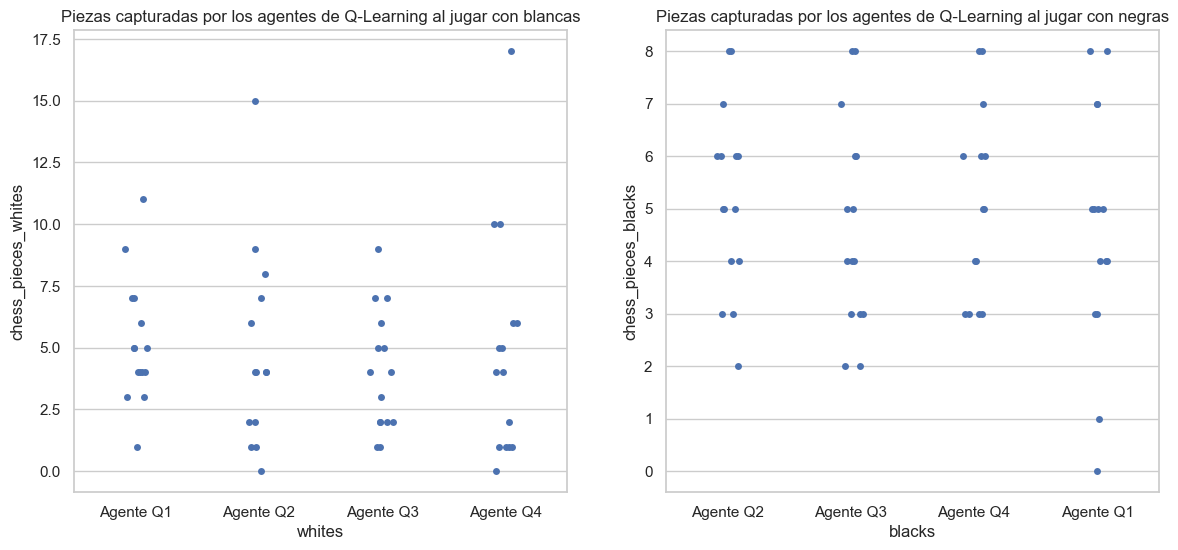

In [114]:
create_strip_plot(datos, "chess_pieces", "Piezas capturadas por los agentes de Q-Learning")

      Agente   Blancas    Negras
0  Agente Q1  5.200000  4.600000
1  Agente Q2  4.785714  5.200000
2  Agente Q3  4.000000  4.666667
3  Agente Q4  4.866667  5.071429


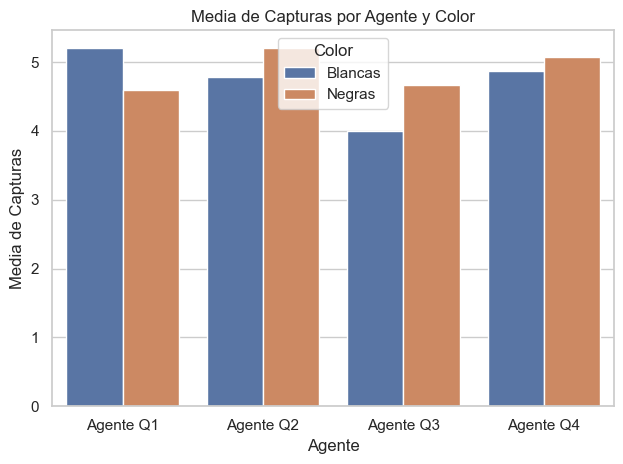

In [115]:
capturas_agentes = calcula_medias_variable(datos, "chess_pieces")

print(capturas_agentes)

captura_agentes_extendido = pd.melt(capturas_agentes, id_vars=['Agente'], value_vars=['Blancas', 'Negras'],
                                var_name='Color', value_name='Media Capturas')

ax = sns.barplot(x='Agente', y='Media Capturas', hue='Color', data=captura_agentes_extendido)

plt.title('Media de Capturas por Agente y Color')
plt.xlabel('Agente')
plt.ylabel('Media de Capturas')
plt.legend(title='Color')

plt.tight_layout()
plt.show()

Observando la media de capturas por agente y color, podemos ver como el agente 1 es el que mayor media tiene para las blancas, mientras que el agente 2 para las negras.

Ahora visualizaremos los tiempos promedio de decisión de cada agente, y tambien el promedio de tiempos por agente y color en todo el experimento.

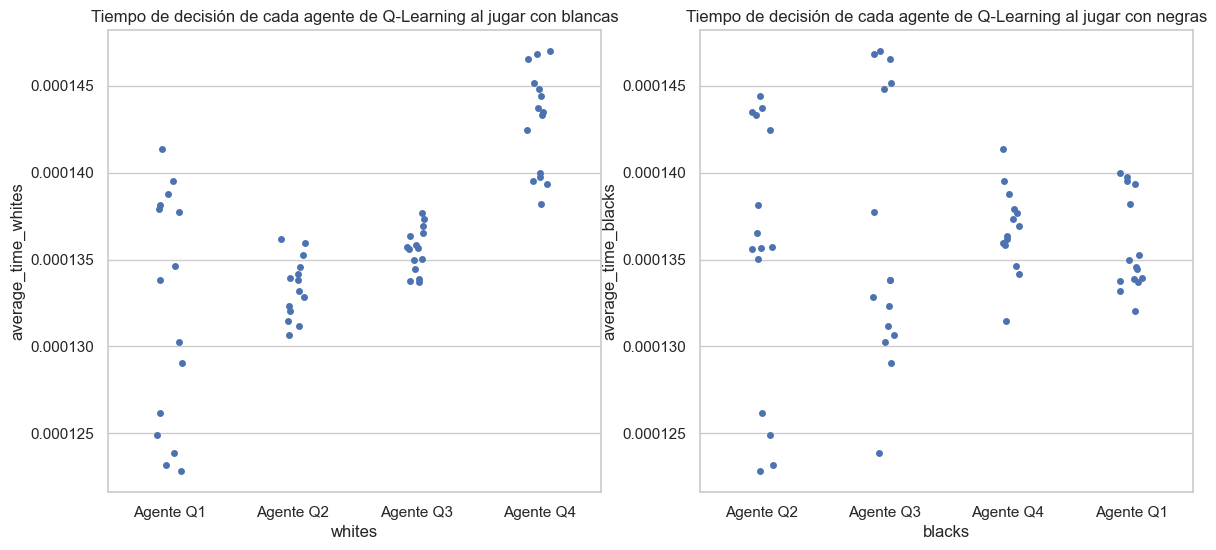

In [116]:
create_strip_plot(datos, 'average_time', 'Tiempo de decisión de cada agente de Q-Learning')

      Agente   Blancas    Negras
0  Agente Q1  0.000132  0.000136
1  Agente Q2  0.000133  0.000135
2  Agente Q3  0.000136  0.000136
3  Agente Q4  0.000143  0.000137


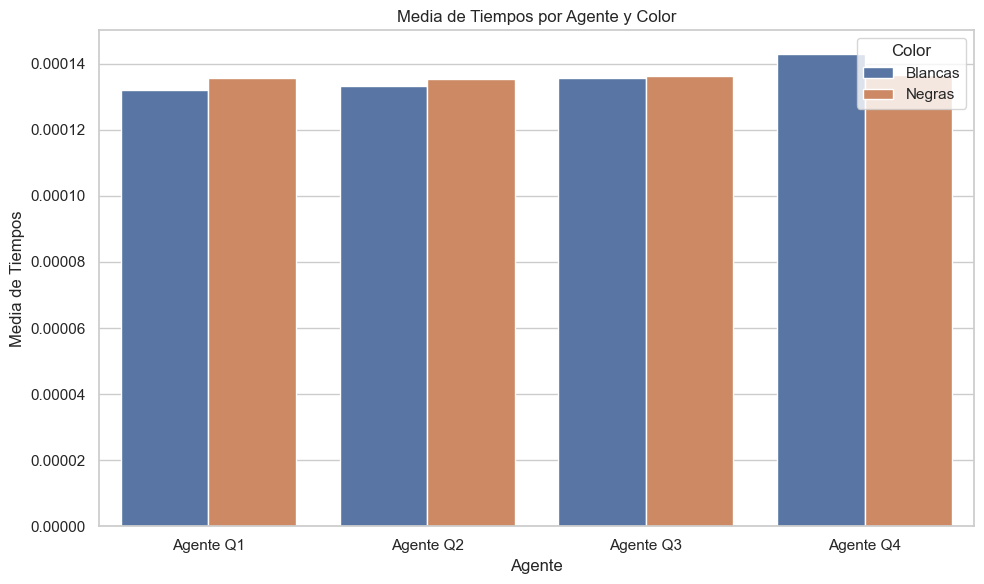

In [117]:
tiempo_agentes = calcula_medias_variable(datos, "average_time")

print(tiempo_agentes)

tiempo_agentes_extendido = pd.melt(tiempo_agentes, id_vars=['Agente'], value_vars=['Blancas', 'Negras'],
                                var_name='Color', value_name='Media_Tiempos')

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Agente', y='Media_Tiempos', hue='Color', data=tiempo_agentes_extendido)

plt.title('Media de Tiempos por Agente y Color')
plt.xlabel('Agente')
plt.ylabel('Media de Tiempos')
plt.legend(title='Color')

plt.tight_layout()
plt.show()

Observamos que los tiempos son bastante similares para todos los agentes, siendo el agente 1 el que menos tiempo ha tardado en tomar una decisión para las blancas, y el agente 2 para las negras.

Comparemos la relación de cada hiperparámetro con el número de piezas capturadas.

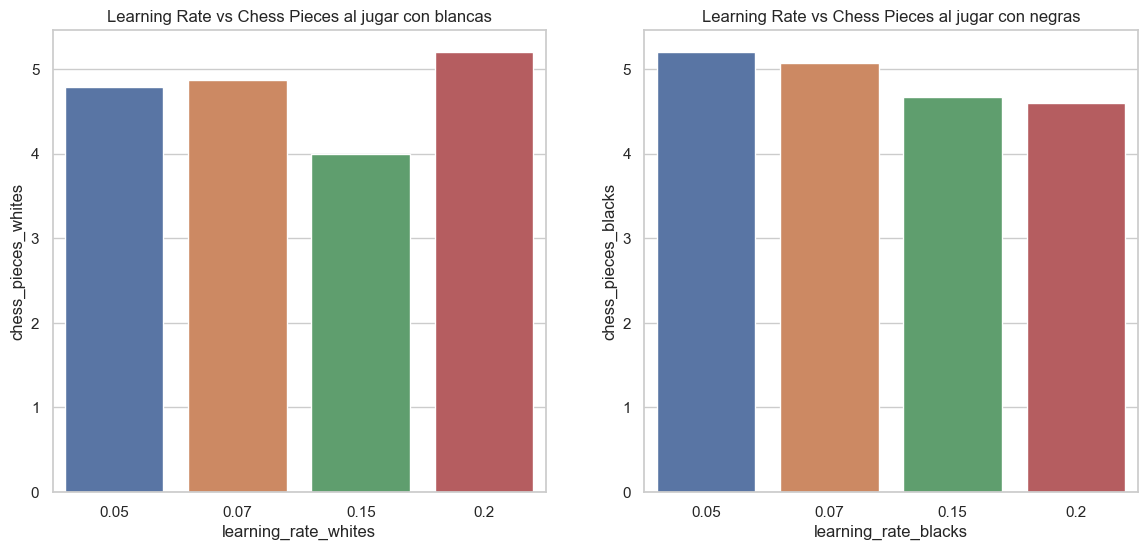

In [118]:
create_bar_plot(df, 'learning_rate', 'chess_pieces', 'Learning Rate vs Chess Pieces')

Esta gráfica muestra la relación entre la tasa de aprendizaje para las fichas blancas y la cantidad de piezas de ajedrez capturadas por las blancas, diferenciando los resultados de las partidas. Observamos que a menor learning rate para las blancas mayor número de piezas capturadas, mientras que para las negras con un learning rate de 0.2 se ha conseguido mayor número de piezas capturadas.

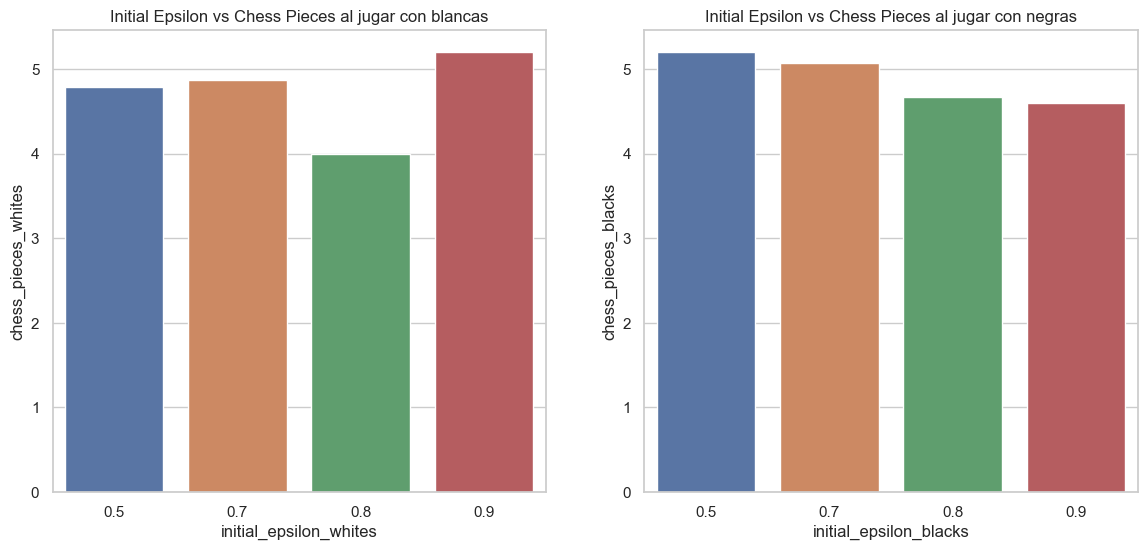

In [119]:
create_bar_plot(df, 'initial_epsilon', 'chess_pieces', 'Initial Epsilon vs Chess Pieces')

Esta gráfica muestra la relación entre el valor inicial de epsilon para las fichas blancas y la cantidad de piezas de ajedrez capturadas por las blancas, diferenciando los resultados de las partidas. Observamos que a mayor valor inicial de epsilon para las blancas mayor número de piezas capturadas, mientras que para las negras con un valor inicial de epsilon de 0.9 se ha conseguido mayor número de piezas capturadas.

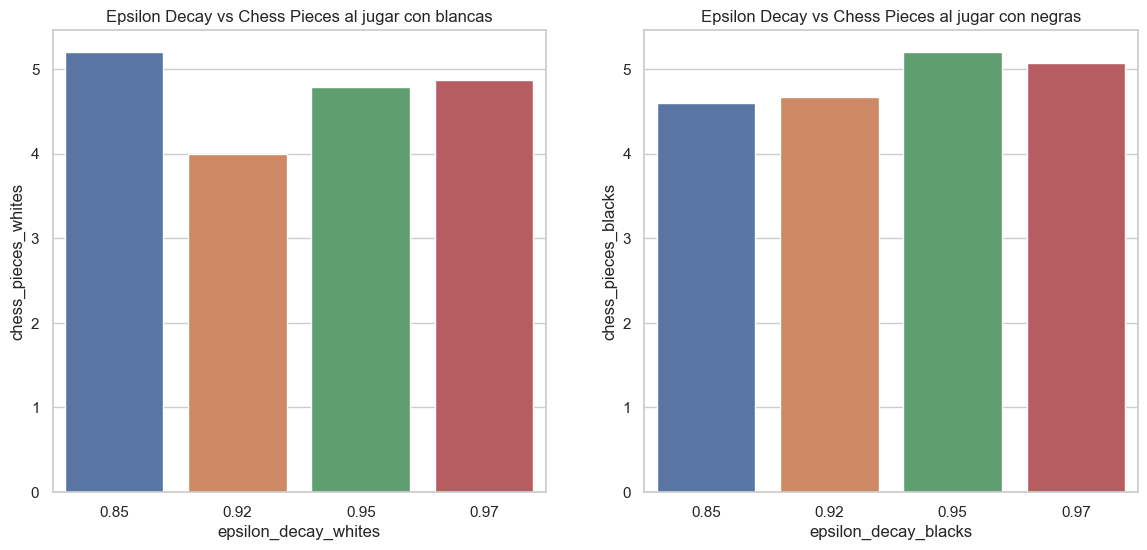

In [120]:
create_bar_plot(df, 'epsilon_decay', 'chess_pieces', 'Epsilon Decay vs Chess Pieces')

Esta gráfica muestra la relación entre el factor de decaimiento de epsilon para las fichas blancas y la cantidad de piezas de ajedrez capturadas por las blancas, diferenciando los resultados de las partidas. Observamos que 0.95 como factor de decaimiento es el que ha obtenido capturar un mayor número de piezas para las blancas, mientras que para las negras con un factor de decaimiento de 0.85 se ha conseguido mayor número de piezas capturadas.

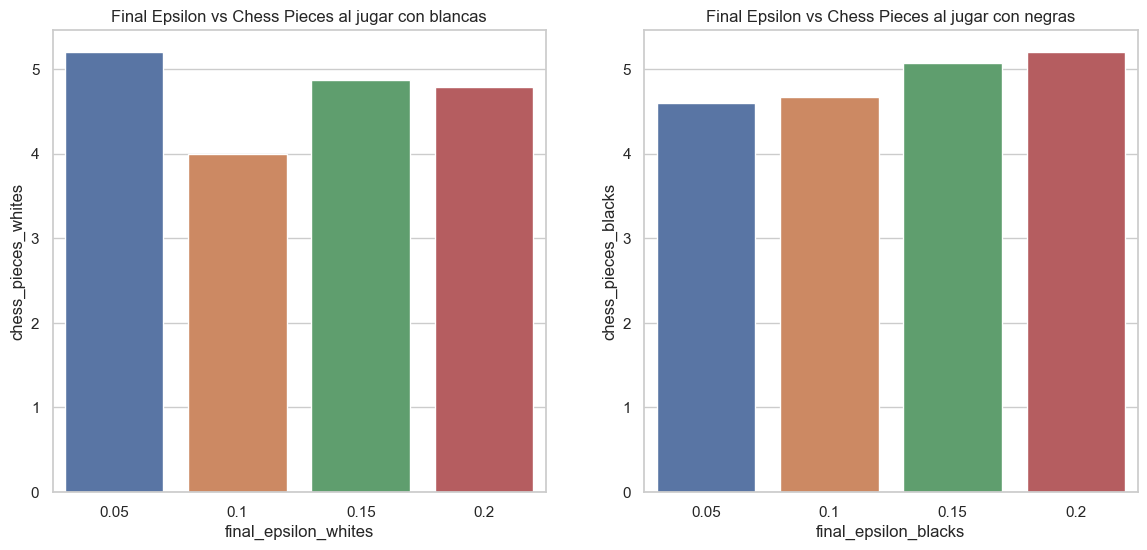

In [121]:
create_bar_plot(df, 'final_epsilon', 'chess_pieces', 'Final Epsilon vs Chess Pieces')

Esta gráfica muestra la relación entre el valor final de epsilon para las fichas blancas y la cantidad de piezas de ajedrez capturadas por las blancas, diferenciando los resultados de las partidas. Observamos que a mayor valor final de epsilon para las blancas mayor número de piezas capturadas, mientras que para las negras con un valor final de epsilon de 0.05 se ha conseguido mayor número de piezas capturadas.

### Conclusiones

Para elaborar unas conclusiones sobre la elección de qué configuración de hiperparámetros es la mejor usaremos la función definida anteriormente para evaluar los agentes.

In [122]:
resultados_blancas = evaluar_agentes(datos, 'blancas')
resultados_blancas

,Ratio_Victorias,Fichas_Promedio,Tiempo_Promedio
whites,,,
Agente Q1,0.533333,5.200000,0.000132
Agente Q4,0.533333,4.866667,0.000143
Agente Q3,0.466667,4.000000,0.000136
Agente Q2,0.428571,4.785714,0.000133


In [123]:
resultados_negras = evaluar_agentes(datos, 'negras')
resultados_negras

,Ratio_Victorias,Fichas_Promedio,Tiempo_Promedio
blacks,,,
Agente Q4,0.642857,5.071429,0.000137
Agente Q1,0.533333,4.600000,0.000136
Agente Q3,0.466667,4.666667,0.000136
Agente Q2,0.400000,5.200000,0.000135


Teniendo en cuenta todos los resultados, para las blancas la mejor configuración de hiperparámetros sería la del Agente 1, mostrando un mayor número de victorias, un mayor promedio de fichas capturadas y un tiempo promedio también muy bueno; mientras que para las negras el Agente 4 debería ser el elegido, ya que ha conseguido un mayor número de victorias y el promedio de fichas capturadas es muy similar al del Agente 2, y el tiempo promedio es similar a todos los agentes.

Por lo tanto, la configuración de blancas sería:
* *Learning rate:* 0.2
* *Initial epsilon:* 0.9
* *Epsilon decay:* 0.85
* *Final epsilon:* 0.05

Y para las negras:
* *Learning rate:* 0.07
* *Initial epsilon:* 0.7
* *Epsilon decay:* 0.97
* *Final epsilon:* 0.15

## Q-Learning vs MCTS

Una vez hemos analizado los resultados de los experimentos con Q-Learning y MCTS por separado, vamos a compararlos para ver cuál de los dos algoritmos ha obtenido mejores resultados, enfrentando a los agentes ganadores de Q-Learning con los de MCTS.

### Lectura de datos

Iniciaremos con la lectura de los datos de los resultados de los experimentos realizados con ambos algoritmos.

In [124]:
df = pd.read_csv('./results/result_q_mcts.csv')
df.head()

,agent_white,agent_black,average_time_whites,chess_pieces_whites,average_time_blacks,chess_pieces_blacks,result
0,1,4,0.000368,7,1.324514,6,Ganan blancas
1,1,4,0.000403,4,1.452691,3,Ganan blancas
2,1,4,0.000430,16,1.610722,3,Ganan blancas
3,1,4,0.000425,3,1.697882,7,Ganan blancas
4,2,3,1.710668,2,0.000424,6,Ganan blancas


El dataset contiene los siguientes campos por cada partida:
* **agent_white:** Agente que juega con las fichas blancas.
* **agent_black:** Agente que juega con las fichas negras.
* **average_time_whites:** Media de tiempo en realizar un movimiento para las fichas blancas.
* **chess_pieces_whites:** Fichas capturadas por las fichas blancas.
* **average_time_blacks:** Media de tiempo en realizar un movimiento para las fichas negras.
* **chess_pieces_blacks** Fichas capturadas por las fichas negras.
* **result:** Resultado de la partida.

## Preprocesado

En este caso no hace falta diferenciar por hiperparámetros, por lo tanto, indicaremos que algoritmo es cada agente.

In [125]:
agentes = {
    "Q-Learning white": 1,
    "Q-Learning black": 3,
    "MCTS white": 2,
    "MCTS black": 4
}

In [126]:
datos = df.copy()

agent_mapping = {
    agent_info: idx 
    for idx, agent_info in agentes.items()
}

def get_agent_name(agent):
    return agent_mapping.get(agent)

datos['agent_white'] = datos.apply(lambda row: get_agent_name(row["agent_white"]), axis=1)
datos['agent_black'] = datos.apply(lambda row: get_agent_name(row["agent_black"]), axis=1)

datos.head()

,agent_white,agent_black,average_time_whites,chess_pieces_whites,average_time_blacks,chess_pieces_blacks,result
0,Q-Learning white,MCTS black,0.000368,7,1.324514,6,Ganan blancas
1,Q-Learning white,MCTS black,0.000403,4,1.452691,3,Ganan blancas
2,Q-Learning white,MCTS black,0.000430,16,1.610722,3,Ganan blancas
3,Q-Learning white,MCTS black,0.000425,3,1.697882,7,Ganan blancas
4,MCTS white,Q-Learning black,1.710668,2,0.000424,6,Ganan blancas


## Visualización

Mostraremos una visualización de los datos para comprenderlos mejor. Comenzaremos por la cantidad de partidas ganadas por cada agente.

In [127]:
datos['winning_agent'] = datos.apply(lambda row: row['agent_white'] if row['result'] == 'Ganan blancas' else row['agent_black'], axis=1)

victories_by_agent = datos['winning_agent'].value_counts().reset_index()
victories_by_agent.columns = ['Agent', 'Victories']

unique_agents = pd.unique(datos[['agent_white', 'agent_black']].values.ravel('K'))

all_agents_victories = pd.DataFrame({'Agent': unique_agents, 'Victories': 0})

for agent in unique_agents:
    if agent in victories_by_agent['Agent'].values:
        all_agents_victories.loc[all_agents_victories['Agent'] == agent, 'Victories'] = victories_by_agent.loc[victories_by_agent['Agent'] == agent, 'Victories'].values[0]

all_agents_victories.sort_values(by='Victories', ascending=False, inplace=True)
all_agents_victories.reset_index(drop=True, inplace=True)
all_agents_victories


,Agent,Victories
0,Q-Learning white,4
1,MCTS white,4
2,Q-Learning black,1
3,MCTS black,0


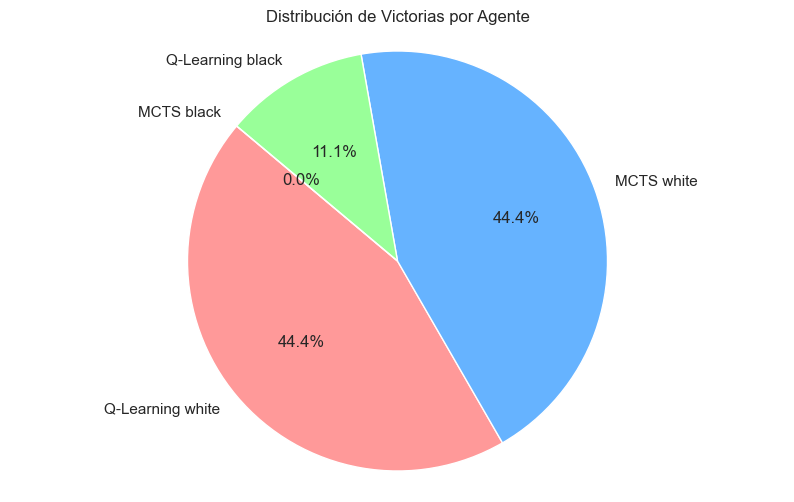

In [128]:
labels = all_agents_victories['Agent']
sizes = all_agents_victories['Victories']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']  

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  

plt.title('Distribución de Victorias por Agente')

plt.show()

Observamos que los Agentes de Q-Learning han ganado más partidas que los de MCTS.

Evaluaremos la media de fichas capturadas por cada algoritmo durante el experimento y la visualizaremos para comprender mejor los resultados.

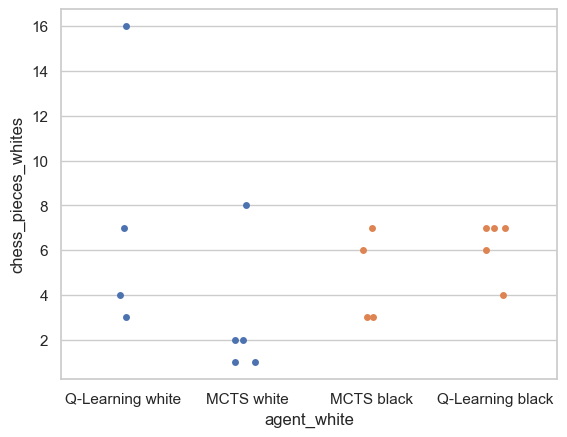

In [129]:
sns.stripplot(data=datos, x="agent_white", y="chess_pieces_whites")
sns.stripplot(data=datos, x="agent_black", y="chess_pieces_blacks")
plt.show()

In [130]:
avg_captured_whites = datos.groupby('agent_white')['chess_pieces_whites'].mean()
avg_captured_blacks = datos.groupby('agent_black')['chess_pieces_blacks'].mean()

avg_captured_data = pd.DataFrame({'Agent': unique_agents})
avg_captured_data['Avg_Captured_as_White'] = avg_captured_data['Agent'].map(avg_captured_whites).fillna(0)
avg_captured_data['Avg_Captured_as_Black'] = avg_captured_data['Agent'].map(avg_captured_blacks).fillna(0)

avg_captured_data['Avg_Captured'] = avg_captured_data['Avg_Captured_as_White'] + avg_captured_data['Avg_Captured_as_Black']

avg_captured_data.drop(['Avg_Captured_as_White', 'Avg_Captured_as_Black'], axis=1, inplace=True)

avg_captured_data

,Agent,Avg_Captured
0,Q-Learning white,7.50
1,MCTS white,2.80
2,MCTS black,4.75
3,Q-Learning black,6.20


<Axes: xlabel='Agent', ylabel='Avg_Captured'>

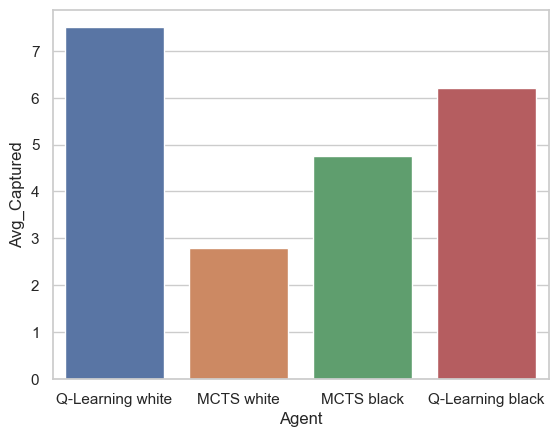

In [131]:
sns.barplot(data=avg_captured_data, x="Agent", y="Avg_Captured")

Y observamos que el agoritmo de Q-Learning es el que más fichas ha capturado.

A continuación, evaluaremos y visualizaremos los tiempos medios de decisión de cada algoritmo.

In [132]:
avg_total_time_whites = datos.groupby('agent_white')['average_time_whites'].mean()
avg_total_time_blacks = datos.groupby('agent_black')['average_time_blacks'].mean()

avg_total_time_data = pd.DataFrame({'Agent': unique_agents})
avg_total_time_data['Avg_Total_Time_as_White'] = avg_total_time_data['Agent'].map(avg_total_time_whites).fillna(0)
avg_total_time_data['Avg_Total_Time_as_Black'] = avg_total_time_data['Agent'].map(avg_total_time_blacks).fillna(0)

avg_total_time_data['Avg_Total_Time'] = avg_total_time_data['Avg_Total_Time_as_White'] + avg_total_time_data['Avg_Total_Time_as_Black']

avg_total_time_data.drop(['Avg_Total_Time_as_White', 'Avg_Total_Time_as_Black'], axis=1, inplace=True)

avg_total_time_data

,Agent,Avg_Total_Time
0,Q-Learning white,0.000407
1,MCTS white,1.589340
2,MCTS black,1.521452
3,Q-Learning black,0.000400


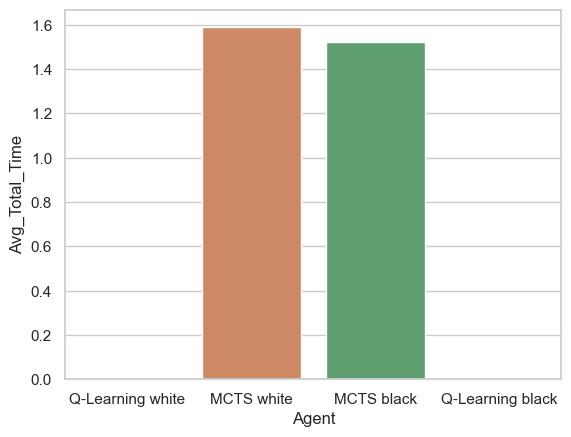

In [133]:
sns.barplot(data=avg_total_time_data, x="Agent", y="Avg_Total_Time")

plt.show()

En este caso el tiempo de los Agentes de Q-Learning son casi 10000 veces más pequeños que los de MCTS, por lo que no son perceptibles en la gráfica.


### Conclusiones

Concluiremos el experimento con la elección del mejor agente.

In [141]:
final = victories_by_agent.merge(avg_captured_data,on='Agent').merge(avg_total_time_data,on='Agent')
final.head(4)4

,Agent,Victories,Avg_Captured,Avg_Total_Time
0,Q-Learning white,4,7.5,0.000407
1,MCTS white,4,2.8,1.589340
2,Q-Learning black,1,6.2,0.000400


Hemos podido observar como los Agentes de Q-Learning han ganado más partidas que los de MCTS, pero a su vez tienen una menor media de fichas capturas y un menor tiempo de juego. Por lo que podemos concluir que los Agentes de Q-Learning son más eficientes que los de MCTS.